In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=150)

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [4]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [5]:
df.Sex.head()


0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [6]:
df.Sex.cat.codes.head()


0    1
1    0
2    0
3    0
4    1
dtype: int8

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


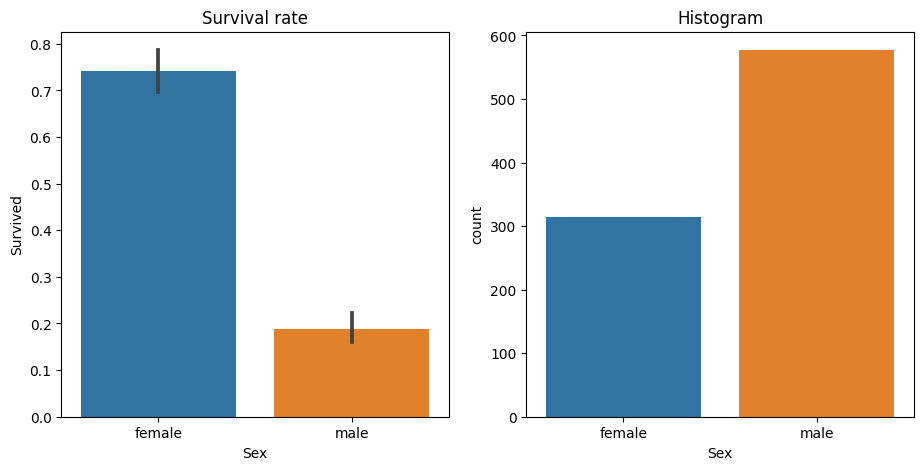

In [7]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.75)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [10]:
preds = val_xs.Sex==0


In [11]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21973094170403587

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


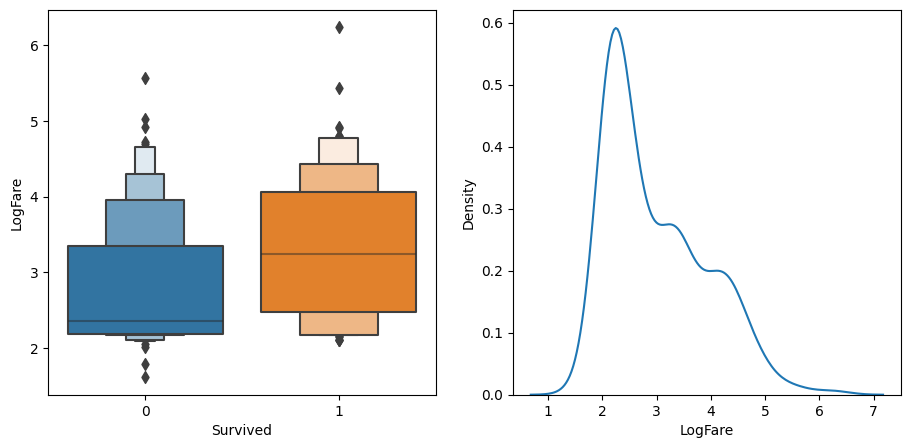

In [16]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [17]:
preds = val_xs.LogFare>2.7


In [18]:
mean_absolute_error(val_y, preds)


0.3796711509715994

In [19]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [20]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [21]:
score(trn_xs["Sex"], trn_y, 0.4)


0.3955388124286033

In [22]:
score(trn_xs["LogFare"], trn_y, 2.5)


0.458063320266941

In [23]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [24]:
interact(nm=cats, split=2)(iscore);


interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [25]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.83,  1.  ,  2.  ,  4.  ,  5.  ,  6.  ,  9.  , 13.  , 14.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 24.  , 24.5 ,
       25.  , 26.  , 27.  , 28.  , 29.  , 30.  , 31.  , 32.  , 33.  , 34.  , 35.  , 36.  , 37.  , 38.  , 39.  , 40.  , 41.  , 42.  , 43.  , 44.  ,
       45.  , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 54.  , 55.  , 56.  , 59.  , 60.  , 61.  , 62.  ])

In [26]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

0.83

In [27]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(0.83, 0.4748084066107871)

In [28]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.3955388124286033),
 'Embarked': (1, 0.4742183457914587),
 'Age': (0.83, 0.4748084066107871),
 'SibSp': (4, 0.4715113111058304),
 'Parch': (3, 0.4819990123056149),
 'LogFare': (2.4423470353692043, 0.458063320266941),
 'Pclass': (2, 0.465547766683801)}

In [29]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [30]:
{o:min_col(males, o) for o in cols}


{'Embarked': (0, 0.3722649438977984),
 'Age': (0.83, 0.3581975673662951),
 'SibSp': (1, 0.3618701199394978),
 'Parch': (1, 0.3682941870426567),
 'LogFare': (2.4423470353692043, 0.3584767208697496),
 'Pclass': (1, 0.36755984130818253)}

In [31]:
{o:min_col(females, o) for o in cols}


{'Embarked': (2, 0.42558939344309715),
 'Age': (45.0, 0.39435641562972007),
 'SibSp': (4, 0.39984984984455946),
 'Parch': (2, 0.4218130571985817),
 'LogFare': (2.737880811060884, 0.387457051256285),
 'Pclass': (2, 0.3367554313199334)}

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=5).fit(trn_xs, trn_y);

In [33]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.8, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

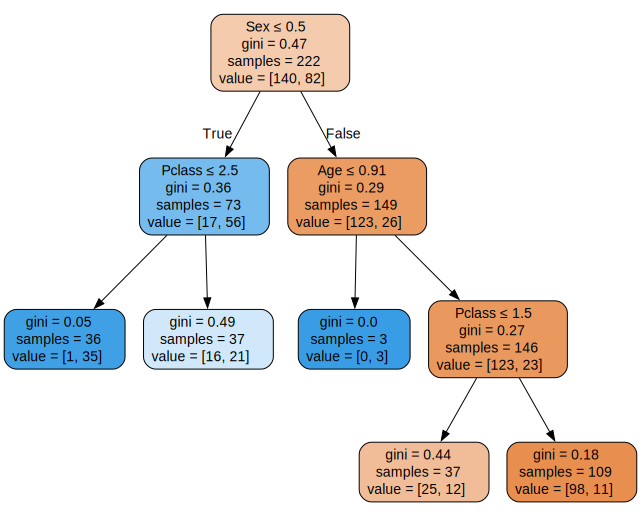

In [34]:
draw_tree(m, trn_xs, size=12)


In [35]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [36]:
gini(df.Sex=='female'), gini(df.Sex=='male')


(0.3828350034484158, 0.3064437162277842)

In [37]:
mean_absolute_error(val_y, m.predict(val_xs))


0.21823617339312407

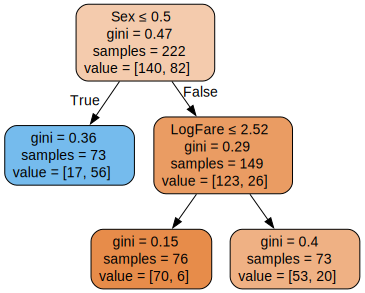

In [39]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=15)

In [40]:
mean_absolute_error(val_y, m.predict(val_xs))


0.21973094170403587

In [41]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [42]:
df.Embarked.head()


0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [43]:
df.Embarked.cat.codes.head()


0    2
1    0
2    2
3    2
4    2
dtype: int8

In [44]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [45]:
trees = [get_tree() for t in range(100)]


In [46]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.24835575485799702

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.2077727952167414

In [48]:
subm(rf.predict(tst_xs), 'rf')


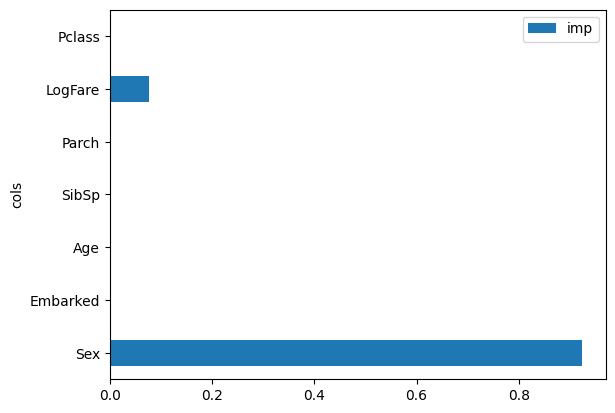

In [49]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');